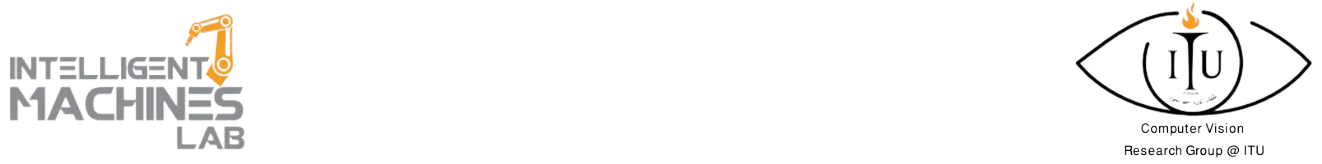

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: `Rabia Shakoor`

Reg No: `msds23019`

Github Link: `your github link here`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader


from torchvision import datasets, transforms
import torch.optim as optim

# Model Definition

In [ ]:
import torch
import torch.nn as nn

def weights_init(m):
    """
    Initializes weights using He initialization.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)


class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()

        # Initialize the encoder layers
        modules = []
        in_channels = input_channels
        for h_dim in h_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.ReLU()
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)

        # Fully connected layers to output mean and log variance
        self.fc_mu = nn.Linear(h_dims[-1]*7*7, latent_dims)
        self.fc_logvar = nn.Linear(h_dims[-1]*7*7, latent_dims)

        # Initialize the decoder layers
        modules = []
        self.decoder_input = nn.Linear(latent_dims, h_dims[-1] * 7 * 7)
        hidden_dims = list(reversed(h_dims))

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.ReLU()
                )
            )

        self.decoder = nn.Sequential(*modules)

        # Final layer to reconstruct input (1 channel for grayscale output)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        # Apply weight initialization using weights_init
        self.apply(weights_init)

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        x = self.decoder_input(z)
        x = x.view(-1, 64, 7, 7)
        x = self.decoder(x)
        x = self.final_layer(x)
        return x

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)  # Expected output shape: (1, 1, 28, 28)


torch.Size([1, 1, 28, 28])


# Dataset Loading

In [ ]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 15
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 800

In [ ]:
# TODO: Load the MNIST dataset and prepare the dataloaders.
# You can use the torchvision.datasets.MNIST and torch.utils.data.DataLoader to load the dataset.
# You will need separate daataloader for train and test set
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def load_dataset(batch_size):
    transform = transforms.ToTensor()

    # Load MNIST dataset with the correct transformation
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Load the dataset
train_loader, test_loader = load_dataset(BATCH_SIZE)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51086230.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1819646.60it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10580646.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3297650.82it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=9):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

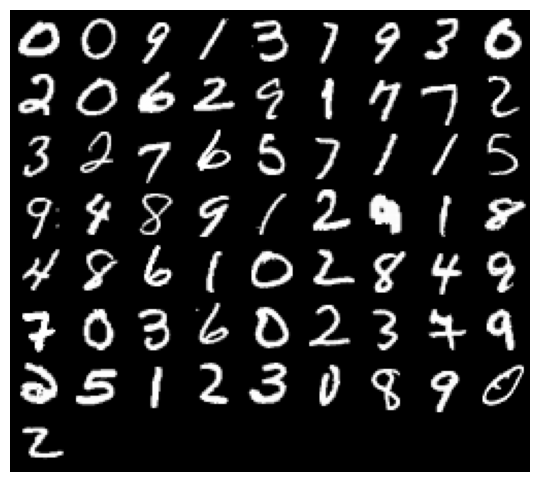

In [ ]:
def plot_images(images, nrow=9):
    plt.figure(figsize=(10, 6))
    grid_img = make_grid(images, nrow=nrow, padding=0, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray_r')
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
plot_images(images)


# Training Loop

In [ ]:
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    # TODO: Implement the VAE loss function
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = reconstruction_loss + kl_divergence
    return total_loss


In [ ]:
from tqdm import tqdm

# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.

model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
eval_losses = []

# Training Loop
model.train()

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    eval_loss = 0.0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(DEVICE)

        optimizer.zero_grad()
        reconstructed_data, mu, logvar = model(data)
        loss = vae_loss(reconstructed_data, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

        # TODO: Implement the evaluation loop
    model.eval()
    with torch.no_grad():
      for data, _ in test_loader:
        data = data.to(DEVICE)
        reconstructed_data, mu, logvar = model(data)
        loss = vae_loss(reconstructed_data, data, mu, logvar)
        eval_loss += loss.item()

    eval_losses.append(eval_loss / len(test_loader))

print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Eval Loss: {eval_losses[-1]:.4f}")

100%|██████████| 938/938 [00:54<00:00, 17.09it/s]


Epoch: 15/15, Train Loss: 6888.6388, Eval Loss: 6800.7734


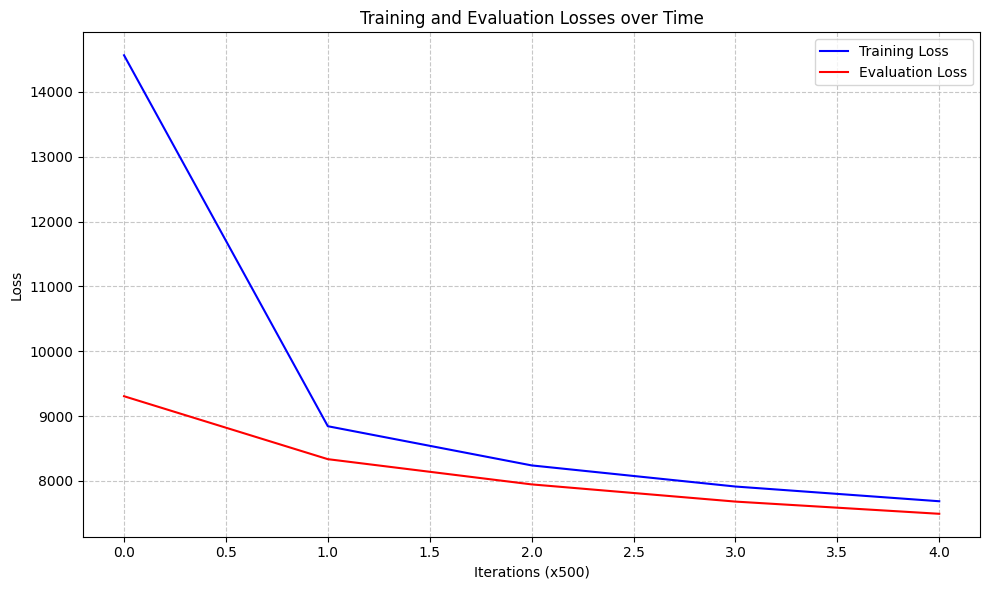

In [ ]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

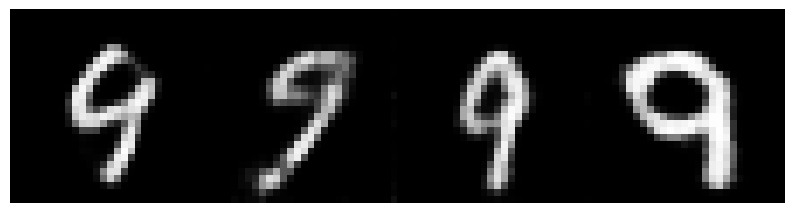

In [ ]:
def visualize_generations(model, digit, num_examples):
   # TODO: Implement the visualize_generations function
    # You will first encode the digit images into their latent space encodings
    # Then you will sample from the latent space and decode the samples to get the reconstructed images
    # You will then plot the reconstructed images
    # Use the plot_image function to plot the images
    # Set the model to evaluation mode
    model.eval()

    # Get the digit images from the test loader
    digit_images = []
    for data, labels in train_loader:
        digit_images.extend(data[labels == digit].cpu())
        if len(digit_images) >= num_examples:
            break

    digit_images = torch.stack(digit_images[:num_examples]).to(DEVICE)
    with torch.no_grad():
        mu, logvar = model.encode(digit_images)

    # Sample from the latent space
    z_samples = model.reparametrize(mu, logvar)

    with torch.no_grad():
        generated_images = model.decode(z_samples)

    plot_images(generated_images)

# Usage
digit = 9
num_examples = 4
visualize_generations(model, digit, num_examples)


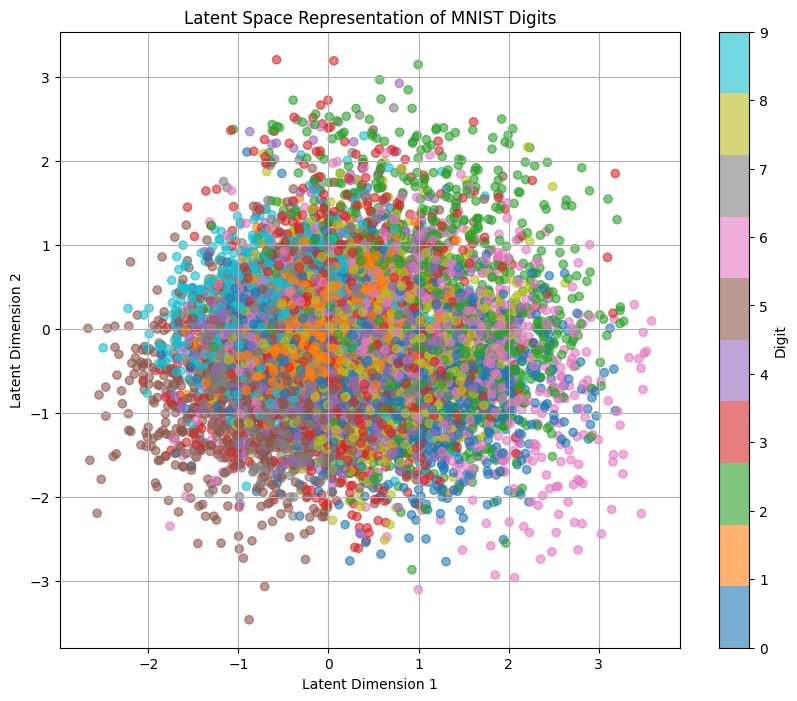

In [ ]:
def visualize_latens(dataloader, model):
   # TODO: Implement the visualize_latens function
    # Set your model's latent space to 2 and train the model
    # Encode all samples from MNIST test loader to the latent space
    # Plot them using scatter plot to show how your model has been able differentiate between them
    model.eval()
    all_mu = []
    all_labels = []

    # Iterate through the dataloader to encode all samples
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(DEVICE)
            mu, _ = model.encode(data)  # Get mu; we don't need logvar for visualization
            all_mu.append(mu.cpu())
            all_labels.append(labels.cpu())

    # Concatenate all the mu tensors and labels
    all_mu = torch.cat(all_mu)
    all_labels = torch.cat(all_labels)

    # Plotting the latent space representations
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, ticks=range(10), label='Digit')
    plt.title('Latent Space Representation of MNIST Digits')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()

# Usage
visualize_latens(test_loader, model)
